# Quantum Fourier Transform Benchmark

In [1]:
low = 3
high = 10
samples = 100

In [2]:
import time
import random
import math

## PyQrack

In [3]:
from pyqrack import QrackSimulator, Pauli

def bench_qrack(n):
    sim = QrackSimulator(n)
    num_qubits = sim.num_qubits()
    # |0> state QFT is "trivial" for Qrack, so we give it a realistic case instead.
    for i in range(num_qubits):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.time()
    qubits = [i for i in range(num_qubits)]
    sim.qft(qubits)
    sim.m_all()

    return time.time() - start

qrack_results = {}
for n in range(low, high + 1):
        width_results = []
        
        # Run the benchmarks
        for i in range(samples):
            width_results.append(bench_qrack(n))

        qrack_results[n] = sum(width_results) / samples

print(qrack_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{3: 0.00013460636138916017, 4: 0.00017776966094970703, 5: 0.00023998022079467772, 6: 0.0002939581871032715, 7: 0.00039194107055664064, 8: 0.000494384765625, 9: 0.0006641769409179688, 10: 0.000845179557800293}


## Qiskit Aer

In [4]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.time()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.time() - start

aer_results = {}
for n in range(low, high + 1):
        width_results = []
        
        # Run the benchmarks
        for i in range(samples):
            width_results.append(bench_aer(n))

        aer_results[n] = sum(width_results) / samples

print(aer_results)

{3: 0.004599013328552246, 4: 0.005250499248504638, 5: 0.005535433292388916, 6: 0.006610774993896484, 7: 0.0072317194938659665, 8: 0.008080761432647705, 9: 0.009159114360809326, 10: 0.010472078323364258}


## QCGPU

In [5]:
import qcgpu

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.time()

    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    state.measure()

    state.backend.queue.finish()
    return time.time() - start

qcgpu_results = {}
for n in range(low, high + 1):
        width_results = []
        
        # Run the benchmarks
        for i in range(samples):
            width_results.append(bench_qcgpu(n))

        qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{3: 0.0015632987022399902, 4: 0.00236994743347168, 5: 0.0032993435859680178, 6: 0.004457728862762451, 7: 0.006031675338745117, 8: 0.00785085916519165, 9: 0.010231194496154785, 10: 0.011467664241790772}


## Results

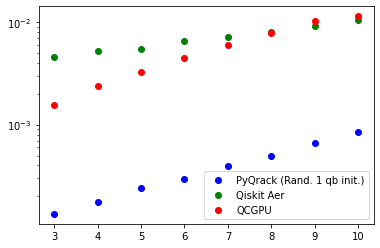

In [6]:
import matplotlib.pyplot as plt

colors = list("rgb")

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop())

plt.legend(["PyQrack (Rand. 1 qb init.)", "Qiskit Aer", "QCGPU"])
plt.yscale("log")
plt.show()